In [308]:
import os
import copy
import stanza
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display
#stanza.download('en')

import corenlp
os.environ["CORENLP_HOME"] = "./NaturalLanguagePipeline\lib\stanford-corenlp-4.1.0"

nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma,depparse')

2020-10-10 06:18:08 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-10-10 06:18:08 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-10-10 06:18:08 INFO: Use device: gpu
2020-10-10 06:18:08 INFO: Loading: tokenize
2020-10-10 06:18:08 INFO: Loading: pos
2020-10-10 06:18:10 INFO: Loading: lemma
2020-10-10 06:18:10 INFO: Loading: depparse
2020-10-10 06:18:11 INFO: Done loading processors!


In [378]:
relationPriority = {    
    "BIND": 9,
    "conj:verb": 10,
    "amod": 10,
    "compound": 10,
    "expl": 10,
    "det": 15,
    "cc": 15,
    "conj:adj": 16,
    "conj:np": 16,
    "appos": 16,
    "acl:relcl": 16,
    "acl": 16,
    "acl-other": 16,
    "cop": 20,
    "obj": 20,
    "obj:wh": 20,
    "mark": 20,
    "aux:pass": 30,
    "aux": 30,
    "xcomp": 30,
    "nmod:poss": 40,
    "nmod:npmod": 40,
    "nmod:tmod": 40,
    "nmod:count": 40,
    "nmod": 40,
    "obl": 40,
    "obl:npmod": 40,
    "advmod": 40,
    "advmod:count": 40,
    "advcl": 40,
    "ccomp": 40,
    "nummod":41,
    "conj":45,
    "conj:vp": 45,
    "nsubj": 60,
    "nsubj:pass": 60,
    "nsubj:wh": 60,
    "case": 70,
    "conj:sent": 80,
    "punct": 90,
    "root": 90,
}

def dependencyParse(text):
    parse_trees = []
    
    with corenlp.CoreNLPClient(annotators="tokenize ssplit pos lemma depparse".split()) as client:
        ann = client.annotate(text)

        sentence = ann.sentence[0]
        words = {}
        for token in sentence.token:
            words[token.tokenEndIndex] = [token.word, token.pos]
            
        deps = []
        targets = []
        nodes = sentence.basicDependencies.node
        for edge in sentence.basicDependencies.edge:
            if edge.dep != "punct":
                targets.append(words[edge.target][0])
                deps.append([edge.dep, words[edge.target][0], words[edge.source][0]])

        postags = {}
        for wordid in words:
            word = words[wordid][0]
            if not word in targets:
                deps.append(['root', word, 'root'])
            postags[word] = [wordid, words[wordid][1]]
            
    return deps, postags

def dependencyparse(sentence):
    postag = {}
    parsed = nlp(sentence.lower())
    parse_tree = [postProcess(sent, word, postag) for sent in parsed.sentences for word in sent.words]
    return (parse_tree, postag)
    
def postProcess(sent, word, postag):
    if word.text not in postag:
        postag[word.text] = (word.id, word.upos, word.xpos)
    tree_node = [word.deprel, word.text, sent.words[word.head-1].text if word.head > 0 else "root"]
    printTree(tree_node, postag[word.text])
    return tree_node

def printTree(tree, tag):
    print(f'word: {tree[1]}\thead: {tree[2]}\tdeprel: {tree[0]} \tid: {tag[0]} \tnpos: {tag[1]} \txpos: {tag[2]}', sep='\n')

In [379]:
class BinaryDependencyTree:
    def __init__(self, val, left, right, wid=None, npos=None, xpos=None):
        self.val = val
        self.left = left
        self.right = right
        self.mark = "0"
        self.id = wid
        self.npos = npos
        self.xpos = xpos
        
    def isTree(self):
        return not (type(self.left) is str and type(self.right) is str)
    
    def getVal(self):
        return self.val
    
    def getLeft(self):
        return self.left
    
    def getRight(self):
        return self.right
    
class DependencyTree:
    def __init__(self, val, children):
        self.val = val
        self.children = children
        
    def isTree(self):
        return len(self.children) != 0
    
    def getVal(self):
        return self.val
    
    def getChildren(self):
        return self.children
    
    def addChildren(self, child):
        self.children.append(child)

In [380]:
def composeMulti(head, rel, parseTable):
    children = list(filter(lambda x: x[2] == head, parseTable))
    if len(children) == 0:
        return DependencyTree([rel, head], [])
    
    treeChildren = []
    for child in children:
        childTree = composeMulti(child[1], child[0], parseTable)
        treeChildren.append(childTree)
        
    depTree = DependencyTree([rel, head], treeChildren)
    return depTree

def makeDepTree(parseTable):
    root = list(filter(lambda x: x[2] == "root", parseTable))[0][1]
    return composeMulti(root, "root", parseTable) 


class Binarizer:
    def __init__(self, parseTable=None, postag=None):
        self.postag = postag
        self.parseTable = parseTable
        
    def compose(self, head):
        children = list(filter(lambda x: x[2] == head, self.parseTable))
        children.sort(key=(lambda x: relationPriority[x[0]]), reverse=True)
        if len(children) == 0:
            tag = self.postag[head]
            return BinaryDependencyTree(head, "N", "N", tag[0], tag[1])
        else: 
            topDep = children[0]
        self.parseTable.remove(topDep)
        left = self.compose(topDep[1])
        right = self.compose(topDep[2])
        binaryTree = BinaryDependencyTree(topDep[0], left, right)
        return binaryTree

    def binarization(self):
        root = list(filter(lambda x: x[0] == "root", self.parseTable))[0][1]
        return self.compose(root)  
    

In [381]:
arrows = {
    "+" : "\u2191",
    "-" : "\u2193",
    "=" : "=",
    "0" : ""
}

def btreeToList(binaryDepdency, length):
    annotated = [0] * length
    def toList(tree):
        treelist = []
        if tree.getVal() not in relationPriority:
            treelist.append(tree.npos)
            word = tree.getVal() + arrows[tree.mark]
            index = tree.id
            annotated[int(index)-1] = word
            treelist.append(word)
        else:
            treelist.append(tree.getVal()+ arrows[tree.mark])
        
        left = tree.getLeft()
        right = tree.getRight()

        if left is not 'N':
            treelist.append(toList(left))
       
        if right is not 'N':
            treelist.append(toList(right))

        return treelist
    return toList(binaryDepdency), annotated

def treeToList(depdency):
    def toList(tree):
        treelist = []
        val = tree.getVal()
        label = str(val[0]) + '<' +str(val[1]) + '>'
        treelist.append(label)
        
        children = tree.getChildren()
        for child in children:
            treelist.append(toList(child)) 

        return treelist
    return toList(depdency)

In [382]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree_img/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree_img/tree.ps ../data/tree_img/tree.png')
    display(Image(filename='../data/tree_img/tree.png'))

In [393]:
negate_mark = {
    "+":"-",
    "-":"+",
    "=":"="
}

det_mark = {
    "det:univ": ("+", "-"),
    "det:exist": ("+", "+"),
    "det:limit": ("+", "="),
    "det:negation": ("+", "-")
}

det_type_words = {
    "det:univ": ["all", "every", "each", "both"],
    "det:exist": ["a", "an", "some"],
    "det:limit": ["the", "this", "that", "those", "these", "my", "his", "her"],
    "det:negation": ["no", "neither"]
}

def det_type(word):
    for det in det_type_words:
        if word.lower() in det_type_words[det]:
            print(det)
            return det

In [431]:
class Polarizer:
    def __init__(self, dependtree):
        self.dependtree = dependtree
        self.polarize_function = {
            "nsubj": self.polarize_nsubj,
            "nsubj:pass": self.polarize_nsubj,
            "det": self.polarize_det,
            "obj": self.polarize_obj,
            "case": self.polarize_case,
            "obl": self.polarize_obl,
            "amod": self.polarize_amod,
            "conj": self.polarize_inherite,
            "cc"  : self.polarize_cc,
            "advmod" : self.polarize_inherite,
            "aux": self.polarize_inherite,
            "aux:pass": self.polarize_inherite,
            "obl:npmod": self.polarize_oblnpmod,
            "nummod": self.polarize_nummod,
            "cop": self.polarize_inherite,
            "xcomp": self.polarize_inherite,
            "mark": self.polarize_inherite,
            "nmod": self.polarize_nmod,
            "compound": self.polarize_inherite,
            "ccomp": self.polarize_ccomp
            
        }
        #self.isNegate = False
        
    def polarize_deptree(self):
        self.polarize(self.dependtree)
        #if self.isNegate:
        
    def polarize(self, tree):
        if tree.isTree():
            self.polarize_function[tree.val](tree)
        else:
            print(tree.val + tree.mark)

    def polarize_nsubj(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        right.mark = '+'
        if right.isTree():
            self.polarize(right)

        if left.isTree():
            self.polarize(left)
        else:
            left.mark = '+'
            
        tree.mark = right.mark
        
    def polarize_obj(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        if right.isTree():
            self.polarize(right)
        else:
            right.mark = '+'

        if left.isTree():
            self.polarize(left)
        else:
            left.mark = '+'
            
        tree.mark = left.mark
        
    def polarize_obl(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        left.mark = tree.mark
        if left.isTree():
            self.polarize(left)
        else:
            left.mark = '+'
        
        right.mark = tree.mark
        if right.isTree():
            self.polarize(right)
        else:
            left.mark = '+'
        
    def polarize_det(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        detType = det_type(left.val)
        #print(left.val)
        #print(detType)
        detMark = det_mark[detType]
        
        tree.mark = detMark[1]
        right.mark = detMark[1]
        
        if right.isTree():
            self.polarize(right)
        
        left.mark = detMark[0]
        if detType == "det:negation":
            #self.isNegate = True
            self.negate(self.dependtree)
            
    def polarize_inherite(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        right.mark = tree.mark
        if right.isTree():
            self.polarize(right)
            
        left.mark = right.mark
        if left.isTree():
            self.polarize(left)
            
    def polarize_cc(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        left.mark = '+'
        if right.isTree():
            self.polarize(right)
        else:
            right.mark = tree.mark
            
    def polarize_amod(self, tree):
        left = tree.getLeft()
        right = tree.getRight()
        
        if left.val.lower() in ["many", "most"]:
            left.mark = "+"
            right.mark = "="
            if right.isTree():
                self.polarize(right)
        else:
            self.polarize_inherite(tree)
            
    def polarize_case(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        left.mark = tree.mark
        right.mark = tree.mark
        
        if right.val ==  "least":
            tree.mark = "-"
        elif right.val == "most":
            tree.mark = "+"
            self.negate(self.dependtree)
        else:
            if right.isTree():
                self.polarize(right)
            if left.isTree():
                self.polarize(left)
            
    def polarize_oblnpmod(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        self.polarize(left)
        right.mark = left.mark
                
    def polarize_nummod(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        right.mark = "+"
        if right.isTree():
            self.polarize(right)
            
        if left.isTree():
            self.polarize(left)
        else:
            left.mark = "+"
            right.mark = "="
            self.equalize(self.dependtree)
            
    def polarize_nmod(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        if right.isTree():
            self.polarize(right)
        
        left.mark = right.mark   
        if left.isTree():
            self.polarize(left)
            
        tree.mark = right.mark
            
    def polarize_ccomp(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        if right.isTree():
            self.polarize(right)
            
        print(right.mark)
            
        left.mark = right.mark   
        if left.isTree():
            self.polarize(left)  
            
        tree.mark = right.mark
            
    def equalize(self, tree):
        if tree.isTree():
            if tree.val != "nummod":
                self.equalize(tree.getRight())
                self.equalize(tree.getLeft())
                if tree.mark != "0":
                    tree.mark = "="
        else:
            tree.mark = "="
            
    def negate(self, tree):
        if tree.isTree():
            if not tree.left.val.lower() in ["no", "neither"] and tree.val != "obl:npmod":
                self.negate(tree.getRight())
                self.negate(tree.getLeft())
                if tree.mark != "0":
                    tree.mark = negate_mark[tree.mark]
        else:
            tree.mark = negate_mark[tree.mark]

All dogs eat food
det:univ
[nsubj↑  [det↓  [DT  All↑]  [NNS  dogs↓]]  [obj↑  [NN  food↑]  [VBP  eat↑]]]
All↑  dogs↓  eat↑  food↑


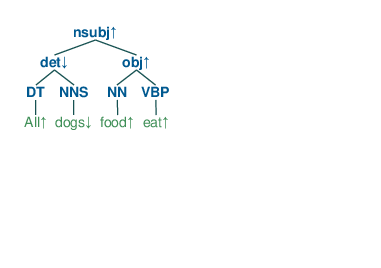

An Irishman won the Nobel prize for literature.
det:limit
det:exist
[nsubj=  [det↑  [DT  An↑]  [NNP  Irishman↑]]  [obj=  [nmod=  [case=  [IN  for=]  [NN  literature=]]  [det=  [DT  the↑]  [compound=  [NNP  Nobel=]  [NN  prize=]]]]  [VBD  won↑]]]
An↑  Irishman↑  won↑  the↑  Nobel=  prize=  for=  literature=


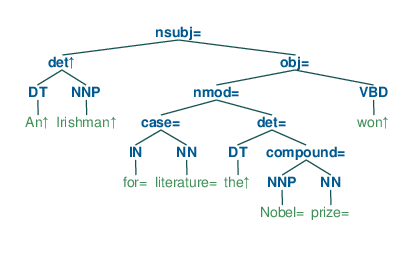

Every European has the right to live in Europe.
det:limit
=
det:univ
[nsubj=  [det↓  [DT  Every↑]  [JJ  European↓]]  [ccomp=  [obl=  [case=  [IN  in=]  [NNP  Europe=]]  [mark=  [TO  to=]  [VB  live=]]]  [obj=  [det=  [DT  the↑]  [NN  right=]]  [VBZ  has↑]]]]
Every↑  European↓  has↑  the↑  right=  to=  live=  in=  Europe=


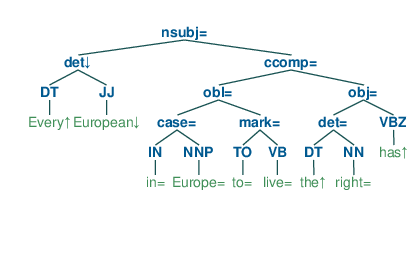

All Europeans have the right to live in Europe.
det:limit
=
det:univ
[nsubj=  [det↓  [DT  All↑]  [NNPS  Europeans↓]]  [ccomp=  [obl=  [case=  [IN  in=]  [NNP  Europe=]]  [mark=  [TO  to=]  [VB  live=]]]  [obj=  [det=  [DT  the↑]  [NN  right=]]  [VBP  have↑]]]]
All↑  Europeans↓  have↑  the↑  right=  to=  live=  in=  Europe=


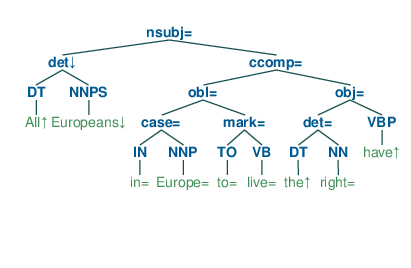

Each European has the right to live in Europe.
det:limit
=
det:univ
[nsubj=  [det↓  [DT  Each↑]  [NNP  European↓]]  [ccomp=  [obl=  [case=  [IN  in=]  [NNP  Europe=]]  [mark=  [TO  to=]  [VB  live=]]]  [obj=  [det=  [DT  the↑]  [NN  right=]]  [VBZ  has↑]]]]
Each↑  European↓  has↑  the↑  right=  to=  live=  in=  Europe=


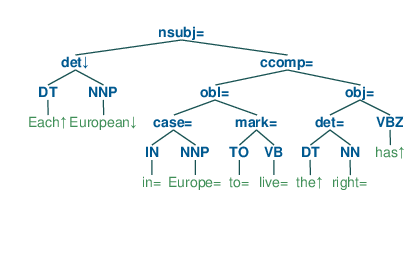

Every European is a person.
det:exist
det:univ
[nsubj↑  [det↓  [DT  Every↑]  [JJ  European↓]]  [cop↑  [VBZ  is↑]  [det↑  [DT  a↑]  [NN  person↑]]]]
Every↑  European↓  is↑  a↑  person↑


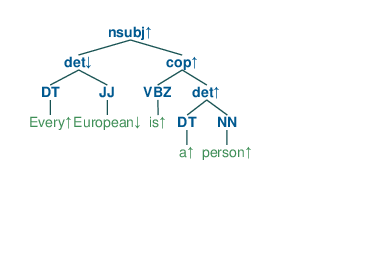

Every person who has the right to live in Europe can travel freely within Europe.


KeyError: 'acl:relcl'

In [433]:
sentences = ["All dogs run", "Some dogs run", "No dog runs", 
             "All dogs sleep at night", "Some dogs eat apples", "No dog eats apples", "That dog eats apples",
             "Many dogs sleep at night. ", "Most dogs sleep at night. ", "A few dogs sleep at night. ",
             "At least 5 dogs sleep at night. ", "At most five dogs eat dinner.","Five dogs are chasing cats",
             "All beautiful dogs eat apples", 
             "Some beautiful dogs eat apples", 
             "No beautiful dogs eat apples", 
             "All beautiful and smart dogs eat apples", 
             "No beautiful and smart dogs eat apples",
             "Some beautiful and smart dogs eat apples",
             "A smart and healthy person sleeps at night",
             "Every smart and healthy people sleep at night",
             "That tall and beautiful flower opens at night",
             "A man is playing the piano happily",
             "Every dog is excitedly chasing some cats",
             "No dog is excitedly chasing some cats",
             "All books here are beautifully printed and absolutely immaculate"]

Conservativity = ["No really great tenors are modest", "Some Italian tenors are great", 
              "The really ambitious tenors are Italian", "Each Italian tenors wants to be great",
              "Many great tenors are German", "Both leading tenors are excellent",
              "Neither leading tenor comes cheap",
              "At least three tenors will take part in the concert", 
              "At most two tenors will contribute their fees to charity", "One of the leading tenor is Pavarotti"
              "Leading tenors who are excellent are indispensable"]

monotonicity = ["All dogs eat food","An Irishman won the Nobel prize for literature.", "Every European has the right to live in Europe.", 
                "All Europeans have the right to live in Europe.", "Each European has the right to live in Europe.",
                "Every European is a person.",
                "Every person who has the right to live in Europe can travel freely within Europe.", 
                "An Italian became the world's greatest tenor"]

#["A school girl with a black bag is on a crowded train", "every animal likes some young semanticist"] 
#"Every good student study the math", "Every young student play the piano", 
#"Some doctors work with no chemist", "Disney won an Oscar for the movie Avengers",
#"There are no dogs that chase cats"

binarizer = Binarizer()

for sent in monotonicity:
    print(sent)
    tree, postag = dependencyParse(sent)
    parseTreeCopy = copy.deepcopy(tree)
    
    # binarization
    binarizer.parseTable = parseTreeCopy
    binarizer.postag = postag
    binaryDepdency = binarizer.binarization()
    #sexpression, annotated = btreeToList(binaryDepdency, len(sent.split()))
    #sexpression = str(sexpression).replace(',', ' ').replace("'", '').replace('[', '(').replace(']', ')')
    #btreeViz = Tree.fromstring(sexpression)
    #jupyter_draw_nltk_tree(btreeViz)
    
    # polarization
    polarizer = Polarizer(binaryDepdency)
    polarizer.polarize_deptree()
    
    # postprocessing
    sexpression, annotated = btreeToList(binaryDepdency, len(sent.split()))
    sexpression = str(sexpression).replace(',', ' ').replace("'", '')
    annotated = str(annotated).replace(',', ' ').replace("'", '').replace("[", "").replace("]", "")
    print(sexpression)
    print(annotated)
    sexpression = sexpression.replace('[', '(').replace(']', ')')
    
    #visualization
    btreeViz = Tree.fromstring(sexpression)
    jupyter_draw_nltk_tree(btreeViz)